# Bitcoin daily closing price LSTM prediction

This is one of my first recurrent NN projects. The goal is to:

- load the data, create a comprehensive training set for the purpose of closing price prediction
- back test on the historical data and see if the model is generalizing well
- create a future data test set to try to predict the BTC price in the future

## Few thoughts on the problem

- I am not really aiming for a good generalizing algorithm; the problem is that the price is quite volatile (and lately quite analogical to stock prices changes all over the world due to the influence of investors coming from the usual financial sector)
- due to this volatility, this project can ONLY be considered as purely educational using popular data. Let's see if I can make this work

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config inlineBackend.figure_format='retina'
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 16, 10
random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [17]:
raw = pd.read_csv('Bitstamp_BTCEUR_d.csv', header=1)
raw.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume EUR
0,1.605485e+09,2020-11-16,BTCEUR,13491.33,13726.95,13424.30,13714.86,203.32,2765168.78
1,1.605398e+09,2020-11-15,BTCEUR,13591.73,13677.00,13337.97,13491.33,880.75,11903040.14
2,1.605312e+09,2020-11-14,BTCEUR,13814.14,13814.14,13295.01,13591.73,1744.07,23535421.23
3,1.605226e+09,2020-11-13,BTCEUR,13834.35,13976.47,13512.46,13814.14,2017.48,27775715.75
4,1.605139e+09,2020-11-12,BTCEUR,13330.99,13860.00,13133.65,13834.35,2691.29,36456228.61


In [18]:
raw = raw[['Date','Close']]

In [19]:
raw.head()

,Date,Close
0,2020-11-16,13714.86
1,2020-11-15,13491.33
2,2020-11-14,13591.73
3,2020-11-13,13814.14
4,2020-11-12,13834.35


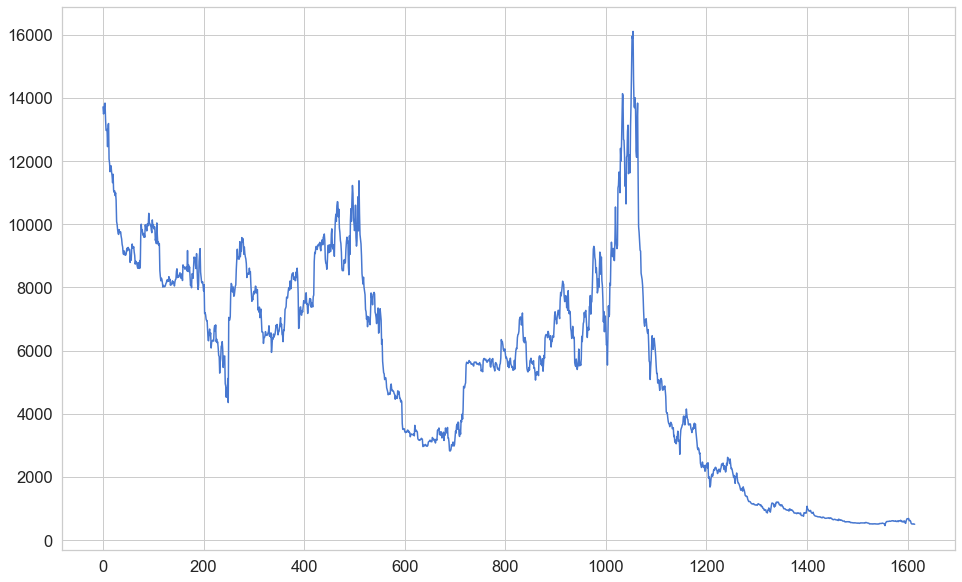

In [20]:
plt.plot(raw['Close'])
plt.show() 

In [21]:
#the data is backwards
raw = raw[::-1]
raw.head()

,Date,Close
1614,2016-06-04,503.00
1613,2016-06-05,505.98
1612,2016-06-06,514.23
1611,2016-06-07,507.94
1610,2016-06-08,513.00


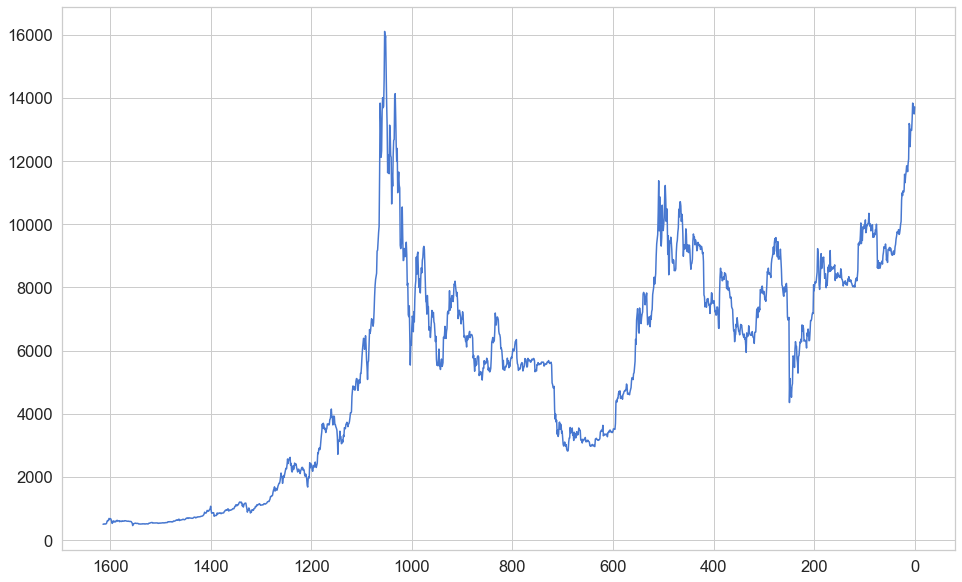

In [22]:
plt.plot(raw['Close'])
plt.gca().invert_xaxis()
plt.show()

In [23]:
#raw.set_index('Date', inplace=True)
#raw.head()

In [24]:
raw['Date'].dtype

dtype('O')

In [25]:
#dealing with the date
raw['Date'] = pd.to_datetime(raw['Date'])

In [26]:
raw.head()

,Date,Close
1614,2016-06-04,503.00
1613,2016-06-05,505.98
1612,2016-06-06,514.23
1611,2016-06-07,507.94
1610,2016-06-08,513.00


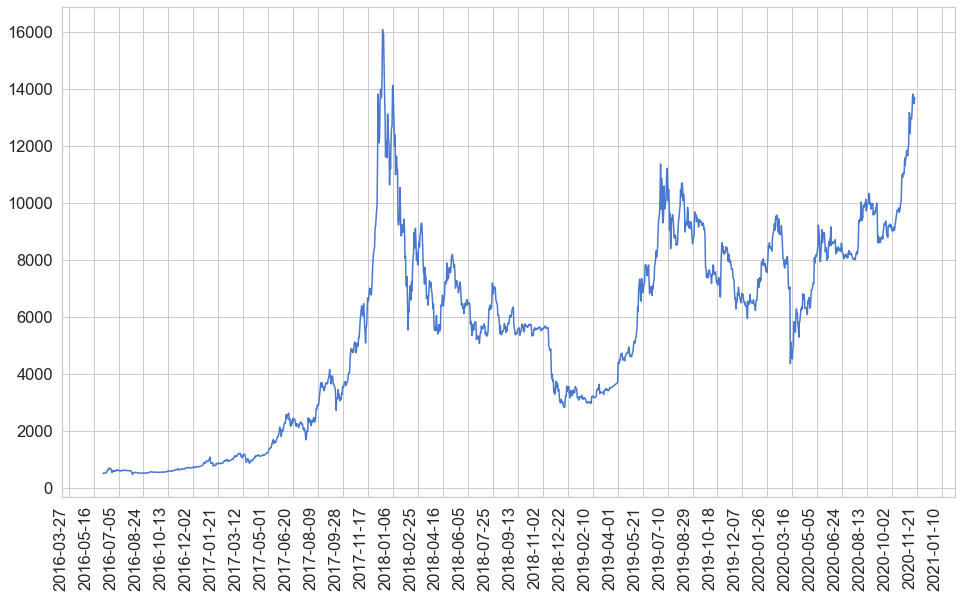

In [27]:
# I want the xticks to be dates, more sparse though

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.plot(raw['Date'], raw['Close'])
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

In [28]:
raw.set_index('Date', inplace = True)

In [29]:
raw.head()

,Close
Date,
2016-06-04,503.00
2016-06-05,505.98
2016-06-06,514.23
2016-06-07,507.94
2016-06-08,513.00


In [30]:
raw.to_csv('Data_prep.csv')

In [31]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [32]:
len(raw)

1615

Let's first try the algorithm on some test data and then train a new one to actually predict the future based on tuning the first one.

In [33]:
from keras.regularizers import L1L2

reg = L1L2(0.0, 0.01)

In [34]:
#I"ll use basic 2-layer LSTM solution for starters
def train_model(X, y, lr = 0.001, patience = 20, epochs = 50, batch_size = 32, val_split = 0.1, do = 0.3, reg=None, call=False):
    if call:
        ES = keras.callbacks.EarlyStopping(monitor = 'loss', patience = patience, restore_best_weights = True)
        callb = [ES]
    else:
        callb = None
    model = keras.Sequential([
        keras.layers.LSTM(128, input_shape = (X.shape[1], X.shape[2]), return_sequences = True, bias_regularizer=reg),
        keras.layers.Dropout(do),
        keras.layers.LSTM(128, bias_regularizer=reg),
        keras.layers.Dense(1)
    ])
    adam = keras.optimizers.Adam(lr)
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    
    
    history = model.fit(X, y, epochs = epochs, batch_size = batch_size, validation_split = val_split, verbose = 1,
                       callbacks = callb, shuffle = False)
    
    return history, model

In [35]:
def test_split(data, test_size = 0.1):
    test_size = int(len(data)*0.1)
    train_size = int(len(data)-test_size)
    
    train_set, test_set = data.iloc[:train_size], data.iloc[train_size:]
    return train_set, test_set

In [36]:
def plot_history(history):
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'validation')
    plt.legend()
    plt.show()
    
def plot_all(y_train, y_test, y_pred):
    plt.plot(np.arange(0,len(y_train)), y_train, 'g', label = 'historical')
    plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, marker = '.', label = 'True')
    plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, 'r', label = 'Prediction')
    plt.xlabel('timestep')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()
    
def plot_detail(y_test, y_pred):
    plt.plot(y_test, marker = '.', label = 'True')
    plt.plot(y_pred, 'r', label='Prediction')
    plt.xlabel('timestep')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

In [37]:
train_set, test_set = test_split(raw)

In [38]:
time_steps = 30
X_train, y_train = create_dataset(train_set, train_set['Close'], time_steps=time_steps)
X_test, y_test = create_dataset(test_set, test_set['Close'], time_steps=time_steps)

In [39]:
to_check = [X_train, y_train, X_test, y_test]

for dt in to_check:
    print('Number of sequences: ',len(dt), '| Set shape: ', dt.shape)

Number of sequences:  1424 | Set shape:  (1424, 30, 1)
Number of sequences:  1424 | Set shape:  (1424,)
Number of sequences:  131 | Set shape:  (131, 30, 1)
Number of sequences:  131 | Set shape:  (131,)


In [40]:
history_1, model_1 = train_model(X_train, y_train, epochs = 5000, reg = reg)

Epoch 1/5000
41/41 [==============================] - 5s 115ms/step - loss: 33450210.0000 - val_loss: 59799896.0000
Epoch 2/5000
41/41 [==============================] - 3s 70ms/step - loss: 33380836.0000 - val_loss: 59722192.0000
Epoch 3/5000
41/41 [==============================] - 3s 68ms/step - loss: 33333954.0000 - val_loss: 59648860.0000
Epoch 4/5000
41/41 [==============================] - 3s 70ms/step - loss: 33289014.0000 - val_loss: 59577376.0000
Epoch 5/5000
41/41 [==============================] - 3s 75ms/step - loss: 33244594.0000 - val_loss: 59507328.0000
Epoch 6/5000
41/41 [==============================] - 3s 76ms/step - loss: 33200642.0000 - val_loss: 59437020.0000
Epoch 7/5000
41/41 [==============================] - 3s 75ms/step - loss: 33156862.0000 - val_loss: 59367604.0000
Epoch 8/5000
41/41 [==============================] - 3s 76ms/step - loss: 33113614.0000 - val_loss: 59298832.0000
Epoch 9/5000
41/41 [==============================] - 3s 77ms/step - loss: 3307

41/41 [==============================] - 3s 79ms/step - loss: 30587346.0000 - val_loss: 55224264.0000
Epoch 72/5000
41/41 [==============================] - 3s 82ms/step - loss: 30549154.0000 - val_loss: 55161932.0000
Epoch 73/5000
41/41 [==============================] - 3s 81ms/step - loss: 30511014.0000 - val_loss: 55099648.0000
Epoch 74/5000
41/41 [==============================] - 3s 81ms/step - loss: 30472926.0000 - val_loss: 55037436.0000
Epoch 75/5000
41/41 [==============================] - 3s 81ms/step - loss: 30434888.0000 - val_loss: 54975280.0000
Epoch 76/5000
41/41 [==============================] - 3s 77ms/step - loss: 30396908.0000 - val_loss: 54913192.0000
Epoch 77/5000
41/41 [==============================] - 3s 81ms/step - loss: 30358970.0000 - val_loss: 54851156.0000
Epoch 78/5000
41/41 [==============================] - 3s 80ms/step - loss: 30321090.0000 - val_loss: 54789184.0000
Epoch 79/5000
41/41 [==============================] - 3s 81ms/step - loss: 30283256.0

41/41 [==============================] - 3s 80ms/step - loss: 28010498.0000 - val_loss: 50962876.0000
Epoch 142/5000
41/41 [==============================] - 3s 81ms/step - loss: 27975466.0000 - val_loss: 50904116.0000
Epoch 143/5000
41/41 [==============================] - 3s 80ms/step - loss: 27940470.0000 - val_loss: 50845408.0000
Epoch 144/5000
41/41 [==============================] - 3s 81ms/step - loss: 27905534.0000 - val_loss: 50786764.0000
Epoch 145/5000
41/41 [==============================] - 3s 82ms/step - loss: 27870642.0000 - val_loss: 50728168.0000
Epoch 146/5000
41/41 [==============================] - 3s 81ms/step - loss: 27835798.0000 - val_loss: 50669644.0000
Epoch 147/5000
41/41 [==============================] - 3s 82ms/step - loss: 27801004.0000 - val_loss: 50611168.0000
Epoch 148/5000
41/41 [==============================] - 3s 82ms/step - loss: 27766254.0000 - val_loss: 50552744.0000
Epoch 149/5000
41/41 [==============================] - 3s 81ms/step - loss: 27

41/41 [==============================] - 3s 80ms/step - loss: 25672028.0000 - val_loss: 46985124.0000
Epoch 212/5000
41/41 [==============================] - 3s 78ms/step - loss: 25640270.0000 - val_loss: 46930268.0000
Epoch 213/5000
41/41 [==============================] - 3s 80ms/step - loss: 25608554.0000 - val_loss: 46875460.0000
Epoch 214/5000
41/41 [==============================] - 3s 81ms/step - loss: 25576890.0000 - val_loss: 46820712.0000
Epoch 215/5000
41/41 [==============================] - 3s 79ms/step - loss: 25545274.0000 - val_loss: 46766028.0000
Epoch 216/5000
41/41 [==============================] - 3s 79ms/step - loss: 25513694.0000 - val_loss: 46711384.0000
Epoch 217/5000
41/41 [==============================] - 3s 80ms/step - loss: 25482166.0000 - val_loss: 46656804.0000
Epoch 218/5000
41/41 [==============================] - 3s 78ms/step - loss: 25450680.0000 - val_loss: 46602272.0000
Epoch 219/5000
41/41 [==============================] - 3s 79ms/step - loss: 25

41/41 [==============================] - 3s 80ms/step - loss: 23558318.0000 - val_loss: 43277348.0000
Epoch 282/5000
41/41 [==============================] - 3s 80ms/step - loss: 23529712.0000 - val_loss: 43226312.0000
Epoch 283/5000
41/41 [==============================] - 3s 81ms/step - loss: 23501146.0000 - val_loss: 43175340.0000
Epoch 284/5000
41/41 [==============================] - 3s 81ms/step - loss: 23472628.0000 - val_loss: 43124420.0000
Epoch 285/5000
41/41 [==============================] - 3s 79ms/step - loss: 23444152.0000 - val_loss: 43073544.0000
Epoch 286/5000
41/41 [==============================] - 3s 79ms/step - loss: 23415718.0000 - val_loss: 43022724.0000
Epoch 287/5000
41/41 [==============================] - 3s 79ms/step - loss: 23387334.0000 - val_loss: 42971972.0000
Epoch 288/5000
41/41 [==============================] - 3s 78ms/step - loss: 23358986.0000 - val_loss: 42921268.0000
Epoch 289/5000
41/41 [==============================] - 3s 81ms/step - loss: 23

41/41 [==============================] - 3s 79ms/step - loss: 21734174.0000 - val_loss: 39970724.0000
Epoch 352/5000
41/41 [==============================] - 3s 80ms/step - loss: 21708658.0000 - val_loss: 39923652.0000
Epoch 353/5000
41/41 [==============================] - 3s 79ms/step - loss: 21683190.0000 - val_loss: 39876632.0000
Epoch 354/5000
41/41 [==============================] - 3s 81ms/step - loss: 21657760.0000 - val_loss: 39829668.0000
Epoch 355/5000
41/41 [==============================] - 3s 80ms/step - loss: 21632372.0000 - val_loss: 39782756.0000
Epoch 356/5000
41/41 [==============================] - 3s 80ms/step - loss: 21607028.0000 - val_loss: 39735900.0000
Epoch 357/5000
41/41 [==============================] - 3s 80ms/step - loss: 21581726.0000 - val_loss: 39689096.0000
Epoch 358/5000
41/41 [==============================] - 3s 78ms/step - loss: 21556462.0000 - val_loss: 39642344.0000
Epoch 359/5000
41/41 [==============================] - 3s 79ms/step - loss: 21

41/41 [==============================] - 3s 75ms/step - loss: 20047776.0000 - val_loss: 36802640.0000
Epoch 422/5000
41/41 [==============================] - 3s 78ms/step - loss: 20025122.0000 - val_loss: 36759220.0000
Epoch 423/5000
41/41 [==============================] - 3s 81ms/step - loss: 20002506.0000 - val_loss: 36715856.0000
Epoch 424/5000
41/41 [==============================] - 3s 78ms/step - loss: 19979930.0000 - val_loss: 36672548.0000
Epoch 425/5000
41/41 [==============================] - 3s 81ms/step - loss: 19957394.0000 - val_loss: 36629296.0000
Epoch 426/5000
41/41 [==============================] - 3s 82ms/step - loss: 19934896.0000 - val_loss: 36586080.0000
Epoch 427/5000
41/41 [==============================] - 3s 82ms/step - loss: 19912438.0000 - val_loss: 36542920.0000
Epoch 428/5000
41/41 [==============================] - 3s 80ms/step - loss: 19890020.0000 - val_loss: 36499816.0000
Epoch 429/5000
41/41 [==============================] - 3s 79ms/step - loss: 19

41/41 [==============================] - 3s 78ms/step - loss: 18799938.0000 - val_loss: 34372752.0000
Epoch 492/5000
41/41 [==============================] - 3s 80ms/step - loss: 18779972.0000 - val_loss: 34333176.0000
Epoch 493/5000
41/41 [==============================] - 3s 79ms/step - loss: 18760044.0000 - val_loss: 34293644.0000
Epoch 494/5000
41/41 [==============================] - 3s 77ms/step - loss: 18740154.0000 - val_loss: 34254168.0000
Epoch 495/5000
41/41 [==============================] - 3s 77ms/step - loss: 18720302.0000 - val_loss: 34214740.0000
Epoch 496/5000
41/41 [==============================] - 3s 79ms/step - loss: 18700486.0000 - val_loss: 34175368.0000
Epoch 497/5000
41/41 [==============================] - 3s 80ms/step - loss: 18680710.0000 - val_loss: 34136040.0000
Epoch 498/5000
41/41 [==============================] - 3s 80ms/step - loss: 18660964.0000 - val_loss: 34096768.0000
Epoch 499/5000
41/41 [==============================] - 3s 78ms/step - loss: 18

41/41 [==============================] - 4s 96ms/step - loss: 17489042.0000 - val_loss: 31719840.0000
Epoch 562/5000
41/41 [==============================] - 3s 82ms/step - loss: 17471550.0000 - val_loss: 31683630.0000
Epoch 563/5000
41/41 [==============================] - 4s 88ms/step - loss: 17454088.0000 - val_loss: 31647462.0000
Epoch 564/5000
41/41 [==============================] - 4s 96ms/step - loss: 17436662.0000 - val_loss: 31611332.0000
Epoch 565/5000
41/41 [==============================] - 4s 91ms/step - loss: 17419270.0000 - val_loss: 31575270.0000
Epoch 566/5000
41/41 [==============================] - 4s 100ms/step - loss: 17401910.0000 - val_loss: 31539236.0000
Epoch 567/5000
41/41 [==============================] - 4s 96ms/step - loss: 17384588.0000 - val_loss: 31503260.0000
Epoch 568/5000
41/41 [==============================] - 4s 97ms/step - loss: 17367292.0000 - val_loss: 31467324.0000
Epoch 569/5000
41/41 [==============================] - 4s 94ms/step - loss: 1

Epoch 631/5000
41/41 [==============================] - 1s 28ms/step - loss: 16344142.0000 - val_loss: 29296162.0000
Epoch 632/5000
41/41 [==============================] - 1s 28ms/step - loss: 16328929.0000 - val_loss: 29263148.0000
Epoch 633/5000
41/41 [==============================] - 1s 27ms/step - loss: 16313744.0000 - val_loss: 29230180.0000
Epoch 634/5000
41/41 [==============================] - 1s 27ms/step - loss: 16298592.0000 - val_loss: 29197260.0000
Epoch 635/5000
41/41 [==============================] - 1s 27ms/step - loss: 16283471.0000 - val_loss: 29164382.0000
Epoch 636/5000
41/41 [==============================] - 1s 28ms/step - loss: 16268378.0000 - val_loss: 29131544.0000
Epoch 637/5000
41/41 [==============================] - 1s 28ms/step - loss: 16253324.0000 - val_loss: 29098770.0000
Epoch 638/5000
41/41 [==============================] - 1s 27ms/step - loss: 16238291.0000 - val_loss: 29066030.0000
Epoch 639/5000
41/41 [==============================] - 1s 28ms/

41/41 [==============================] - 1s 28ms/step - loss: 15352508.0000 - val_loss: 27092006.0000
Epoch 702/5000
41/41 [==============================] - 1s 27ms/step - loss: 15339391.0000 - val_loss: 27062062.0000
Epoch 703/5000
41/41 [==============================] - 1s 27ms/step - loss: 15326303.0000 - val_loss: 27032166.0000
Epoch 704/5000
41/41 [==============================] - 1s 28ms/step - loss: 15313243.0000 - val_loss: 27002306.0000
Epoch 705/5000
41/41 [==============================] - 1s 27ms/step - loss: 15300207.0000 - val_loss: 26972478.0000
Epoch 706/5000
41/41 [==============================] - 1s 28ms/step - loss: 15287201.0000 - val_loss: 26942704.0000
Epoch 707/5000
41/41 [==============================] - 1s 27ms/step - loss: 15274227.0000 - val_loss: 26912984.0000
Epoch 708/5000
41/41 [==============================] - 1s 27ms/step - loss: 15261277.0000 - val_loss: 26883284.0000
Epoch 709/5000
41/41 [==============================] - 1s 27ms/step - loss: 15

41/41 [==============================] - 1s 28ms/step - loss: 14501154.0000 - val_loss: 25097246.0000
Epoch 772/5000
41/41 [==============================] - 1s 27ms/step - loss: 14489947.0000 - val_loss: 25070216.0000
Epoch 773/5000
41/41 [==============================] - 1s 28ms/step - loss: 14478764.0000 - val_loss: 25043214.0000
Epoch 774/5000
41/41 [==============================] - 1s 28ms/step - loss: 14467601.0000 - val_loss: 25016256.0000
Epoch 775/5000
41/41 [==============================] - 1s 28ms/step - loss: 14456466.0000 - val_loss: 24989352.0000
Epoch 776/5000
41/41 [==============================] - 1s 28ms/step - loss: 14445361.0000 - val_loss: 24962482.0000
Epoch 777/5000
41/41 [==============================] - 1s 28ms/step - loss: 14434278.0000 - val_loss: 24935654.0000
Epoch 778/5000
41/41 [==============================] - 1s 28ms/step - loss: 14423221.0000 - val_loss: 24908848.0000
Epoch 779/5000
41/41 [==============================] - 1s 28ms/step - loss: 14

41/41 [==============================] - 1s 28ms/step - loss: 13776632.0000 - val_loss: 23300408.0000
Epoch 842/5000
41/41 [==============================] - 1s 28ms/step - loss: 13767137.0000 - val_loss: 23276126.0000
Epoch 843/5000
41/41 [==============================] - 1s 28ms/step - loss: 13757665.0000 - val_loss: 23251858.0000
Epoch 844/5000
41/41 [==============================] - 1s 28ms/step - loss: 13748211.0000 - val_loss: 23227630.0000
Epoch 845/5000
41/41 [==============================] - 1s 28ms/step - loss: 13738780.0000 - val_loss: 23203460.0000
Epoch 846/5000
41/41 [==============================] - 1s 28ms/step - loss: 13729380.0000 - val_loss: 23179314.0000
Epoch 847/5000
41/41 [==============================] - 1s 28ms/step - loss: 13719992.0000 - val_loss: 23155210.0000
Epoch 848/5000
41/41 [==============================] - 1s 28ms/step - loss: 13710634.0000 - val_loss: 23131136.0000
Epoch 849/5000
41/41 [==============================] - 1s 28ms/step - loss: 13

41/41 [==============================] - 1s 28ms/step - loss: 13165365.0000 - val_loss: 21689042.0000
Epoch 912/5000
41/41 [==============================] - 1s 28ms/step - loss: 13157387.0000 - val_loss: 21667292.0000
Epoch 913/5000
41/41 [==============================] - 1s 28ms/step - loss: 13149432.0000 - val_loss: 21645592.0000
Epoch 914/5000
41/41 [==============================] - 1s 28ms/step - loss: 13141494.0000 - val_loss: 21623926.0000
Epoch 915/5000
41/41 [==============================] - 1s 28ms/step - loss: 13133579.0000 - val_loss: 21602288.0000
Epoch 916/5000
41/41 [==============================] - 1s 28ms/step - loss: 13125680.0000 - val_loss: 21580684.0000
Epoch 917/5000
41/41 [==============================] - 1s 28ms/step - loss: 13117805.0000 - val_loss: 21559122.0000
Epoch 918/5000
41/41 [==============================] - 1s 28ms/step - loss: 13109951.0000 - val_loss: 21537596.0000
Epoch 919/5000
41/41 [==============================] - 1s 28ms/step - loss: 13

41/41 [==============================] - 1s 28ms/step - loss: 12653917.0000 - val_loss: 20249790.0000
Epoch 982/5000
41/41 [==============================] - 1s 28ms/step - loss: 12647269.0000 - val_loss: 20230410.0000
Epoch 983/5000
41/41 [==============================] - 1s 28ms/step - loss: 12640641.0000 - val_loss: 20211060.0000
Epoch 984/5000
41/41 [==============================] - 1s 28ms/step - loss: 12634028.0000 - val_loss: 20191752.0000
Epoch 985/5000
41/41 [==============================] - 1s 28ms/step - loss: 12627435.0000 - val_loss: 20172464.0000
Epoch 986/5000
41/41 [==============================] - 1s 28ms/step - loss: 12620861.0000 - val_loss: 20153214.0000
Epoch 987/5000
41/41 [==============================] - 1s 28ms/step - loss: 12614303.0000 - val_loss: 20133998.0000
Epoch 988/5000
41/41 [==============================] - 1s 30ms/step - loss: 12607761.0000 - val_loss: 20114802.0000
Epoch 989/5000
41/41 [==============================] - 1s 30ms/step - loss: 12

41/41 [==============================] - 1s 28ms/step - loss: 12234883.0000 - val_loss: 18986138.0000
Epoch 1051/5000
41/41 [==============================] - 1s 28ms/step - loss: 12229371.0000 - val_loss: 18968890.0000
Epoch 1052/5000
41/41 [==============================] - 1s 28ms/step - loss: 12223876.0000 - val_loss: 18951672.0000
Epoch 1053/5000
41/41 [==============================] - 1s 28ms/step - loss: 12218394.0000 - val_loss: 18934474.0000
Epoch 1054/5000
41/41 [==============================] - 1s 28ms/step - loss: 12212932.0000 - val_loss: 18917328.0000
Epoch 1055/5000
41/41 [==============================] - 1s 28ms/step - loss: 12207484.0000 - val_loss: 18900194.0000
Epoch 1056/5000
41/41 [==============================] - 1s 28ms/step - loss: 12202046.0000 - val_loss: 18883098.0000
Epoch 1057/5000
41/41 [==============================] - 1s 28ms/step - loss: 12196621.0000 - val_loss: 18866004.0000
Epoch 1058/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 11888618.0000 - val_loss: 17862972.0000
Epoch 1120/5000
41/41 [==============================] - 1s 28ms/step - loss: 11884084.0000 - val_loss: 17847676.0000
Epoch 1121/5000
41/41 [==============================] - 1s 28ms/step - loss: 11879559.0000 - val_loss: 17832384.0000
Epoch 1122/5000
41/41 [==============================] - 1s 28ms/step - loss: 11875046.0000 - val_loss: 17817126.0000
Epoch 1123/5000
41/41 [==============================] - 1s 30ms/step - loss: 11870549.0000 - val_loss: 17801896.0000
Epoch 1124/5000
41/41 [==============================] - 1s 28ms/step - loss: 11866063.0000 - val_loss: 17786698.0000
Epoch 1125/5000
41/41 [==============================] - 1s 29ms/step - loss: 11861589.0000 - val_loss: 17771512.0000
Epoch 1126/5000
41/41 [==============================] - 1s 28ms/step - loss: 11857127.0000 - val_loss: 17756368.0000
Epoch 1127/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 11604381.0000 - val_loss: 16867092.0000
Epoch 1189/5000
41/41 [==============================] - 1s 28ms/step - loss: 11600671.0000 - val_loss: 16853530.0000
Epoch 1190/5000
41/41 [==============================] - 1s 28ms/step - loss: 11596969.0000 - val_loss: 16839992.0000
Epoch 1191/5000
41/41 [==============================] - 1s 28ms/step - loss: 11593277.0000 - val_loss: 16826476.0000
Epoch 1192/5000
41/41 [==============================] - 1s 29ms/step - loss: 11589597.0000 - val_loss: 16812996.0000
Epoch 1193/5000
41/41 [==============================] - 1s 29ms/step - loss: 11585929.0000 - val_loss: 16799518.0000
Epoch 1194/5000
41/41 [==============================] - 1s 29ms/step - loss: 11582272.0000 - val_loss: 16786084.0000
Epoch 1195/5000
41/41 [==============================] - 1s 29ms/step - loss: 11578622.0000 - val_loss: 16772665.0000
Epoch 1196/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 11372490.0000 - val_loss: 15985777.0000
Epoch 1258/5000
41/41 [==============================] - 1s 28ms/step - loss: 11369472.0000 - val_loss: 15973793.0000
Epoch 1259/5000
41/41 [==============================] - 1s 28ms/step - loss: 11366460.0000 - val_loss: 15961818.0000
Epoch 1260/5000
41/41 [==============================] - 1s 28ms/step - loss: 11363457.0000 - val_loss: 15949871.0000
Epoch 1261/5000
41/41 [==============================] - 1s 28ms/step - loss: 11360467.0000 - val_loss: 15937948.0000
Epoch 1262/5000
41/41 [==============================] - 1s 28ms/step - loss: 11357482.0000 - val_loss: 15926041.0000
Epoch 1263/5000
41/41 [==============================] - 1s 28ms/step - loss: 11354508.0000 - val_loss: 15914161.0000
Epoch 1264/5000
41/41 [==============================] - 1s 29ms/step - loss: 11351540.0000 - val_loss: 15902283.0000
Epoch 1265/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 11184343.0000 - val_loss: 15206923.0000
Epoch 1327/5000
41/41 [==============================] - 1s 28ms/step - loss: 11181899.0000 - val_loss: 15196337.0000
Epoch 1328/5000
41/41 [==============================] - 1s 28ms/step - loss: 11179466.0000 - val_loss: 15185766.0000
Epoch 1329/5000
41/41 [==============================] - 1s 28ms/step - loss: 11177038.0000 - val_loss: 15175215.0000
Epoch 1330/5000
41/41 [==============================] - 1s 29ms/step - loss: 11174611.0000 - val_loss: 15164683.0000
Epoch 1331/5000
41/41 [==============================] - 1s 29ms/step - loss: 11172199.0000 - val_loss: 15154165.0000
Epoch 1332/5000
41/41 [==============================] - 1s 28ms/step - loss: 11169795.0000 - val_loss: 15143676.0000
Epoch 1333/5000
41/41 [==============================] - 1s 28ms/step - loss: 11167399.0000 - val_loss: 15133200.0000
Epoch 1334/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 11032462.0000 - val_loss: 14519294.0000
Epoch 1396/5000
41/41 [==============================] - 1s 29ms/step - loss: 11030495.0000 - val_loss: 14509955.0000
Epoch 1397/5000
41/41 [==============================] - 1s 29ms/step - loss: 11028534.0000 - val_loss: 14500637.0000
Epoch 1398/5000
41/41 [==============================] - 1s 29ms/step - loss: 11026579.0000 - val_loss: 14491320.0000
Epoch 1399/5000
41/41 [==============================] - 1s 29ms/step - loss: 11024631.0000 - val_loss: 14482020.0000
Epoch 1400/5000
41/41 [==============================] - 1s 29ms/step - loss: 11022686.0000 - val_loss: 14472726.0000
Epoch 1401/5000
41/41 [==============================] - 1s 29ms/step - loss: 11020748.0000 - val_loss: 14463447.0000
Epoch 1402/5000
41/41 [==============================] - 1s 28ms/step - loss: 11018813.0000 - val_loss: 14454195.0000
Epoch 1403/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10910419.0000 - val_loss: 13912504.0000
Epoch 1465/5000
41/41 [==============================] - 1s 28ms/step - loss: 10908839.0000 - val_loss: 13904259.0000
Epoch 1466/5000
41/41 [==============================] - 1s 28ms/step - loss: 10907272.0000 - val_loss: 13896029.0000
Epoch 1467/5000
41/41 [==============================] - 1s 28ms/step - loss: 10905706.0000 - val_loss: 13887812.0000
Epoch 1468/5000
41/41 [==============================] - 1s 28ms/step - loss: 10904143.0000 - val_loss: 13879607.0000
Epoch 1469/5000
41/41 [==============================] - 1s 28ms/step - loss: 10902582.0000 - val_loss: 13871407.0000
Epoch 1470/5000
41/41 [==============================] - 1s 28ms/step - loss: 10901036.0000 - val_loss: 13863240.0000
Epoch 1471/5000
41/41 [==============================] - 1s 29ms/step - loss: 10899487.0000 - val_loss: 13855096.0000
Epoch 1472/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10812782.0000 - val_loss: 13377198.0000
Epoch 1534/5000
41/41 [==============================] - 1s 28ms/step - loss: 10811522.0000 - val_loss: 13369929.0000
Epoch 1535/5000
41/41 [==============================] - 1s 29ms/step - loss: 10810267.0000 - val_loss: 13362660.0000
Epoch 1536/5000
41/41 [==============================] - 1s 28ms/step - loss: 10809014.0000 - val_loss: 13355394.0000
Epoch 1537/5000
41/41 [==============================] - 1s 29ms/step - loss: 10807767.0000 - val_loss: 13348156.0000
Epoch 1538/5000
41/41 [==============================] - 1s 28ms/step - loss: 10806525.0000 - val_loss: 13340938.0000
Epoch 1539/5000
41/41 [==============================] - 1s 29ms/step - loss: 10805288.0000 - val_loss: 13333730.0000
Epoch 1540/5000
41/41 [==============================] - 1s 29ms/step - loss: 10804056.0000 - val_loss: 13326538.0000
Epoch 1541/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10734976.0000 - val_loss: 12904872.0000
Epoch 1603/5000
41/41 [==============================] - 1s 28ms/step - loss: 10733972.0000 - val_loss: 12898448.0000
Epoch 1604/5000
41/41 [==============================] - 1s 28ms/step - loss: 10732974.0000 - val_loss: 12892024.0000
Epoch 1605/5000
41/41 [==============================] - 1s 28ms/step - loss: 10731981.0000 - val_loss: 12885628.0000
Epoch 1606/5000
41/41 [==============================] - 1s 29ms/step - loss: 10730992.0000 - val_loss: 12879253.0000
Epoch 1607/5000
41/41 [==============================] - 1s 28ms/step - loss: 10730007.0000 - val_loss: 12872888.0000
Epoch 1608/5000
41/41 [==============================] - 1s 28ms/step - loss: 10729023.0000 - val_loss: 12866531.0000
Epoch 1609/5000
41/41 [==============================] - 1s 28ms/step - loss: 10728044.0000 - val_loss: 12860187.0000
Epoch 1610/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10673227.0000 - val_loss: 12488060.0000
Epoch 1672/5000
41/41 [==============================] - 1s 28ms/step - loss: 10672433.0000 - val_loss: 12482388.0000
Epoch 1673/5000
41/41 [==============================] - 1s 28ms/step - loss: 10671645.0000 - val_loss: 12476742.0000
Epoch 1674/5000
41/41 [==============================] - 1s 29ms/step - loss: 10670858.0000 - val_loss: 12471094.0000
Epoch 1675/5000
41/41 [==============================] - 1s 28ms/step - loss: 10670075.0000 - val_loss: 12465468.0000
Epoch 1676/5000
41/41 [==============================] - 1s 29ms/step - loss: 10669289.0000 - val_loss: 12459840.0000
Epoch 1677/5000
41/41 [==============================] - 1s 29ms/step - loss: 10668508.0000 - val_loss: 12454212.0000
Epoch 1678/5000
41/41 [==============================] - 1s 29ms/step - loss: 10667730.0000 - val_loss: 12448609.0000
Epoch 1679/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10624400.0000 - val_loss: 12120012.0000
Epoch 1741/5000
41/41 [==============================] - 1s 29ms/step - loss: 10623777.0000 - val_loss: 12115017.0000
Epoch 1742/5000
41/41 [==============================] - 1s 28ms/step - loss: 10623152.0000 - val_loss: 12110025.0000
Epoch 1743/5000
41/41 [==============================] - 1s 29ms/step - loss: 10622532.0000 - val_loss: 12105043.0000
Epoch 1744/5000
41/41 [==============================] - 1s 28ms/step - loss: 10621914.0000 - val_loss: 12100070.0000
Epoch 1745/5000
41/41 [==============================] - 1s 29ms/step - loss: 10621297.0000 - val_loss: 12095102.0000
Epoch 1746/5000
41/41 [==============================] - 1s 28ms/step - loss: 10620680.0000 - val_loss: 12090141.0000
Epoch 1747/5000
41/41 [==============================] - 1s 28ms/step - loss: 10620067.0000 - val_loss: 12085184.0000
Epoch 1748/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10585950.0000 - val_loss: 11794894.0000
Epoch 1810/5000
41/41 [==============================] - 1s 29ms/step - loss: 10585457.0000 - val_loss: 11790467.0000
Epoch 1811/5000
41/41 [==============================] - 1s 28ms/step - loss: 10584965.0000 - val_loss: 11786042.0000
Epoch 1812/5000
41/41 [==============================] - 1s 28ms/step - loss: 10584474.0000 - val_loss: 11781621.0000
Epoch 1813/5000
41/41 [==============================] - 1s 29ms/step - loss: 10583986.0000 - val_loss: 11777220.0000
Epoch 1814/5000
41/41 [==============================] - 1s 28ms/step - loss: 10583501.0000 - val_loss: 11772807.0000
Epoch 1815/5000
41/41 [==============================] - 1s 28ms/step - loss: 10583022.0000 - val_loss: 11768432.0000
Epoch 1816/5000
41/41 [==============================] - 1s 29ms/step - loss: 10582536.0000 - val_loss: 11764056.0000
Epoch 1817/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10555791.0000 - val_loss: 11507468.0000
Epoch 1879/5000
41/41 [==============================] - 1s 29ms/step - loss: 10555405.0000 - val_loss: 11503559.0000
Epoch 1880/5000
41/41 [==============================] - 1s 29ms/step - loss: 10555023.0000 - val_loss: 11499661.0000
Epoch 1881/5000
41/41 [==============================] - 1s 31ms/step - loss: 10554644.0000 - val_loss: 11495766.0000
Epoch 1882/5000
41/41 [==============================] - 1s 29ms/step - loss: 10554260.0000 - val_loss: 11491876.0000
Epoch 1883/5000
41/41 [==============================] - 1s 29ms/step - loss: 10553884.0000 - val_loss: 11487986.0000
Epoch 1884/5000
41/41 [==============================] - 1s 28ms/step - loss: 10553499.0000 - val_loss: 11484096.0000
Epoch 1885/5000
41/41 [==============================] - 1s 29ms/step - loss: 10553126.0000 - val_loss: 11480220.0000
Epoch 1886/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10532244.0000 - val_loss: 11253202.0000
Epoch 1948/5000
41/41 [==============================] - 1s 28ms/step - loss: 10531947.0000 - val_loss: 11249745.0000
Epoch 1949/5000
41/41 [==============================] - 1s 28ms/step - loss: 10531648.0000 - val_loss: 11246295.0000
Epoch 1950/5000
41/41 [==============================] - 1s 29ms/step - loss: 10531352.0000 - val_loss: 11242851.0000
Epoch 1951/5000
41/41 [==============================] - 1s 29ms/step - loss: 10531054.0000 - val_loss: 11239416.0000
Epoch 1952/5000
41/41 [==============================] - 1s 28ms/step - loss: 10530762.0000 - val_loss: 11235971.0000
Epoch 1953/5000
41/41 [==============================] - 1s 28ms/step - loss: 10530463.0000 - val_loss: 11232544.0000
Epoch 1954/5000
41/41 [==============================] - 1s 28ms/step - loss: 10530173.0000 - val_loss: 11229114.0000
Epoch 1955/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 30ms/step - loss: 10513952.0000 - val_loss: 11028109.0000
Epoch 2017/5000
41/41 [==============================] - 1s 30ms/step - loss: 10513723.0000 - val_loss: 11025059.0000
Epoch 2018/5000
41/41 [==============================] - 1s 29ms/step - loss: 10513488.0000 - val_loss: 11022005.0000
Epoch 2019/5000
41/41 [==============================] - 1s 29ms/step - loss: 10513257.0000 - val_loss: 11018953.0000
Epoch 2020/5000
41/41 [==============================] - 1s 30ms/step - loss: 10513029.0000 - val_loss: 11015906.0000
Epoch 2021/5000
41/41 [==============================] - 1s 30ms/step - loss: 10512800.0000 - val_loss: 11012873.0000
Epoch 2022/5000
41/41 [==============================] - 1s 29ms/step - loss: 10512572.0000 - val_loss: 11009836.0000
Epoch 2023/5000
41/41 [==============================] - 1s 29ms/step - loss: 10512344.0000 - val_loss: 11006792.0000
Epoch 2024/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10499814.0000 - val_loss: 10828691.0000
Epoch 2086/5000
41/41 [==============================] - 1s 28ms/step - loss: 10499637.0000 - val_loss: 10825959.0000
Epoch 2087/5000
41/41 [==============================] - 1s 28ms/step - loss: 10499456.0000 - val_loss: 10823245.0000
Epoch 2088/5000
41/41 [==============================] - 1s 28ms/step - loss: 10499283.0000 - val_loss: 10820534.0000
Epoch 2089/5000
41/41 [==============================] - 1s 28ms/step - loss: 10499108.0000 - val_loss: 10817837.0000
Epoch 2090/5000
41/41 [==============================] - 1s 28ms/step - loss: 10498930.0000 - val_loss: 10815143.0000
Epoch 2091/5000
41/41 [==============================] - 1s 29ms/step - loss: 10498757.0000 - val_loss: 10812451.0000
Epoch 2092/5000
41/41 [==============================] - 1s 28ms/step - loss: 10498580.0000 - val_loss: 10809772.0000
Epoch 2093/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10488969.0000 - val_loss: 10651897.0000
Epoch 2155/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488834.0000 - val_loss: 10649485.0000
Epoch 2156/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488695.0000 - val_loss: 10647089.0000
Epoch 2157/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488559.0000 - val_loss: 10644680.0000
Epoch 2158/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488425.0000 - val_loss: 10642284.0000
Epoch 2159/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488289.0000 - val_loss: 10639881.0000
Epoch 2160/5000
41/41 [==============================] - 1s 28ms/step - loss: 10488155.0000 - val_loss: 10637507.0000
Epoch 2161/5000
41/41 [==============================] - 1s 29ms/step - loss: 10488021.0000 - val_loss: 10635116.0000
Epoch 2162/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10480708.0000 - val_loss: 10495015.0000
Epoch 2224/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480601.0000 - val_loss: 10492877.0000
Epoch 2225/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480501.0000 - val_loss: 10490743.0000
Epoch 2226/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480399.0000 - val_loss: 10488627.0000
Epoch 2227/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480298.0000 - val_loss: 10486505.0000
Epoch 2228/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480192.0000 - val_loss: 10484385.0000
Epoch 2229/5000
41/41 [==============================] - 1s 29ms/step - loss: 10480093.0000 - val_loss: 10482265.0000
Epoch 2230/5000
41/41 [==============================] - 1s 29ms/step - loss: 10479992.0000 - val_loss: 10480151.0000
Epoch 2231/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 28ms/step - loss: 10474474.0000 - val_loss: 10355767.0000
Epoch 2293/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474398.0000 - val_loss: 10353863.0000
Epoch 2294/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474322.0000 - val_loss: 10351972.0000
Epoch 2295/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474243.0000 - val_loss: 10350087.0000
Epoch 2296/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474166.0000 - val_loss: 10348189.0000
Epoch 2297/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474092.0000 - val_loss: 10346312.0000
Epoch 2298/5000
41/41 [==============================] - 1s 28ms/step - loss: 10474018.0000 - val_loss: 10344434.0000
Epoch 2299/5000
41/41 [==============================] - 1s 28ms/step - loss: 10473939.0000 - val_loss: 10342571.0000
Epoch 2300/5000
41/41 [==============================] - 1s 28ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10469828.0000 - val_loss: 10232074.0000
Epoch 2362/5000
41/41 [==============================] - 1s 29ms/step - loss: 10469769.0000 - val_loss: 10230369.0000
Epoch 2363/5000
41/41 [==============================] - 1s 29ms/step - loss: 10469712.0000 - val_loss: 10228673.0000
Epoch 2364/5000
41/41 [==============================] - 1s 30ms/step - loss: 10469652.0000 - val_loss: 10227002.0000
Epoch 2365/5000
41/41 [==============================] - 1s 30ms/step - loss: 10469599.0000 - val_loss: 10225315.0000
Epoch 2366/5000
41/41 [==============================] - 1s 28ms/step - loss: 10469543.0000 - val_loss: 10223636.0000
Epoch 2367/5000
41/41 [==============================] - 1s 29ms/step - loss: 10469487.0000 - val_loss: 10221971.0000
Epoch 2368/5000
41/41 [==============================] - 1s 28ms/step - loss: 10469430.0000 - val_loss: 10220293.0000
Epoch 2369/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 29ms/step - loss: 10466420.0000 - val_loss: 10122175.0000
Epoch 2431/5000
41/41 [==============================] - 1s 28ms/step - loss: 10466379.0000 - val_loss: 10120678.0000
Epoch 2432/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466338.0000 - val_loss: 10119177.0000
Epoch 2433/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466298.0000 - val_loss: 10117689.0000
Epoch 2434/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466253.0000 - val_loss: 10116203.0000
Epoch 2435/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466217.0000 - val_loss: 10114718.0000
Epoch 2436/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466173.0000 - val_loss: 10113221.0000
Epoch 2437/5000
41/41 [==============================] - 1s 29ms/step - loss: 10466133.0000 - val_loss: 10111738.0000
Epoch 2438/5000
41/41 [==============================] - 1s 29ms/step - 

41/41 [==============================] - 1s 33ms/step - loss: 10463962.0000 - val_loss: 10024307.0000
Epoch 2500/5000
41/41 [==============================] - 1s 35ms/step - loss: 10463934.0000 - val_loss: 10022973.0000
Epoch 2501/5000
41/41 [==============================] - 1s 35ms/step - loss: 10463904.0000 - val_loss: 10021640.0000
Epoch 2502/5000
41/41 [==============================] - 1s 35ms/step - loss: 10463871.0000 - val_loss: 10020299.0000
Epoch 2503/5000
41/41 [==============================] - 1s 35ms/step - loss: 10463844.0000 - val_loss: 10018964.0000
Epoch 2504/5000
41/41 [==============================] - 2s 38ms/step - loss: 10463815.0000 - val_loss: 10017632.0000
Epoch 2505/5000
41/41 [==============================] - 2s 39ms/step - loss: 10463786.0000 - val_loss: 10016316.0000
Epoch 2506/5000
41/41 [==============================] - 2s 46ms/step - loss: 10463756.0000 - val_loss: 10014984.0000
Epoch 2507/5000
41/41 [==============================] - 2s 41ms/step - 

Epoch 2569/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462231.0000 - val_loss: 9936089.0000
Epoch 2570/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462207.0000 - val_loss: 9934904.0000
Epoch 2571/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462191.0000 - val_loss: 9933733.0000
Epoch 2572/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462169.0000 - val_loss: 9932569.0000
Epoch 2573/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462147.0000 - val_loss: 9931388.0000
Epoch 2574/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462132.0000 - val_loss: 9930219.0000
Epoch 2575/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462110.0000 - val_loss: 9929051.0000
Epoch 2576/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462091.0000 - val_loss: 9927881.0000
Epoch 2577/5000
41/41 [==============================] - 1s 28ms

41/41 [==============================] - 1s 28ms/step - loss: 10461072.0000 - val_loss: 9857728.0000
Epoch 2640/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461060.0000 - val_loss: 9856684.0000
Epoch 2641/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461048.0000 - val_loss: 9855636.0000
Epoch 2642/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461035.0000 - val_loss: 9854600.0000
Epoch 2643/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461023.0000 - val_loss: 9853558.0000
Epoch 2644/5000
41/41 [==============================] - 1s 27ms/step - loss: 10461012.0000 - val_loss: 9852520.0000
Epoch 2645/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460996.0000 - val_loss: 9851482.0000
Epoch 2646/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460982.0000 - val_loss: 9850442.0000
Epoch 2647/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10460351.0000 - val_loss: 9788028.0000
Epoch 2710/5000
41/41 [==============================] - 1s 29ms/step - loss: 10460344.0000 - val_loss: 9787099.0000
Epoch 2711/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460334.0000 - val_loss: 9786179.0000
Epoch 2712/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460328.0000 - val_loss: 9785248.0000
Epoch 2713/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460321.0000 - val_loss: 9784326.0000
Epoch 2714/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460312.0000 - val_loss: 9783411.0000
Epoch 2715/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460306.0000 - val_loss: 9782487.0000
Epoch 2716/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460296.0000 - val_loss: 9781569.0000
Epoch 2717/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10459953.0000 - val_loss: 9725959.0000
Epoch 2780/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459951.0000 - val_loss: 9725144.0000
Epoch 2781/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459950.0000 - val_loss: 9724309.0000
Epoch 2782/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459942.0000 - val_loss: 9723491.0000
Epoch 2783/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459939.0000 - val_loss: 9722673.0000
Epoch 2784/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459935.0000 - val_loss: 9721838.0000
Epoch 2785/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459932.0000 - val_loss: 9721021.0000
Epoch 2786/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459933.0000 - val_loss: 9720204.0000
Epoch 2787/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10459797.0000 - val_loss: 9670669.0000
Epoch 2850/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459795.0000 - val_loss: 9669923.0000
Epoch 2851/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459798.0000 - val_loss: 9669186.0000
Epoch 2852/5000
41/41 [==============================] - 1s 29ms/step - loss: 10459796.0000 - val_loss: 9668455.0000
Epoch 2853/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459795.0000 - val_loss: 9667722.0000
Epoch 2854/5000
41/41 [==============================] - 1s 29ms/step - loss: 10459798.0000 - val_loss: 9666981.0000
Epoch 2855/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459799.0000 - val_loss: 9666251.0000
Epoch 2856/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459795.0000 - val_loss: 9665527.0000
Epoch 2857/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 27ms/step - loss: 10459820.0000 - val_loss: 9621815.0000
Epoch 2920/5000
41/41 [==============================] - 1s 27ms/step - loss: 10459819.0000 - val_loss: 9621142.0000
Epoch 2921/5000
41/41 [==============================] - 1s 27ms/step - loss: 10459821.0000 - val_loss: 9620479.0000
Epoch 2922/5000
41/41 [==============================] - 1s 27ms/step - loss: 10459820.0000 - val_loss: 9619809.0000
Epoch 2923/5000
41/41 [==============================] - 1s 27ms/step - loss: 10459822.0000 - val_loss: 9619137.0000
Epoch 2924/5000
41/41 [==============================] - 1s 27ms/step - loss: 10459825.0000 - val_loss: 9618476.0000
Epoch 2925/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459825.0000 - val_loss: 9617811.0000
Epoch 2926/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459829.0000 - val_loss: 9617156.0000
Epoch 2927/5000
41/41 [==============================] - 1s 27ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10459968.0000 - val_loss: 9578085.0000
Epoch 2990/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459973.0000 - val_loss: 9577519.0000
Epoch 2991/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459979.0000 - val_loss: 9576930.0000
Epoch 2992/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459976.0000 - val_loss: 9576355.0000
Epoch 2993/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459981.0000 - val_loss: 9575788.0000
Epoch 2994/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459986.0000 - val_loss: 9575201.0000
Epoch 2995/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459986.0000 - val_loss: 9574627.0000
Epoch 2996/5000
41/41 [==============================] - 1s 28ms/step - loss: 10459988.0000 - val_loss: 9574062.0000
Epoch 2997/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10460194.0000 - val_loss: 9538831.0000
Epoch 3060/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460203.0000 - val_loss: 9538295.0000
Epoch 3061/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460203.0000 - val_loss: 9537758.0000
Epoch 3062/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460210.0000 - val_loss: 9537228.0000
Epoch 3063/5000
41/41 [==============================] - 1s 27ms/step - loss: 10460214.0000 - val_loss: 9536689.0000
Epoch 3064/5000
41/41 [==============================] - 1s 27ms/step - loss: 10460214.0000 - val_loss: 9536177.0000
Epoch 3065/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460224.0000 - val_loss: 9535646.0000
Epoch 3066/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460226.0000 - val_loss: 9535129.0000
Epoch 3067/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 30ms/step - loss: 10460485.0000 - val_loss: 9504564.0000
Epoch 3130/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460490.0000 - val_loss: 9504103.0000
Epoch 3131/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460498.0000 - val_loss: 9503638.0000
Epoch 3132/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460497.0000 - val_loss: 9503182.0000
Epoch 3133/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460504.0000 - val_loss: 9502712.0000
Epoch 3134/5000
41/41 [==============================] - 1s 29ms/step - loss: 10460507.0000 - val_loss: 9502251.0000
Epoch 3135/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460510.0000 - val_loss: 9501803.0000
Epoch 3136/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460517.0000 - val_loss: 9501328.0000
Epoch 3137/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 27ms/step - loss: 10460809.0000 - val_loss: 9473173.0000
Epoch 3200/5000
41/41 [==============================] - 1s 29ms/step - loss: 10460812.0000 - val_loss: 9472747.0000
Epoch 3201/5000
41/41 [==============================] - 1s 29ms/step - loss: 10460815.0000 - val_loss: 9472322.0000
Epoch 3202/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460824.0000 - val_loss: 9471906.0000
Epoch 3203/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460830.0000 - val_loss: 9471475.0000
Epoch 3204/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460834.0000 - val_loss: 9471053.0000
Epoch 3205/5000
41/41 [==============================] - 1s 28ms/step - loss: 10460836.0000 - val_loss: 9470639.0000
Epoch 3206/5000
41/41 [==============================] - 1s 27ms/step - loss: 10460836.0000 - val_loss: 9470228.0000
Epoch 3207/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 34ms/step - loss: 10461151.0000 - val_loss: 9445885.0000
Epoch 3270/5000
41/41 [==============================] - 1s 33ms/step - loss: 10461155.0000 - val_loss: 9445516.0000
Epoch 3271/5000
41/41 [==============================] - 1s 33ms/step - loss: 10461159.0000 - val_loss: 9445165.0000
Epoch 3272/5000
41/41 [==============================] - 1s 31ms/step - loss: 10461162.0000 - val_loss: 9444799.0000
Epoch 3273/5000
41/41 [==============================] - 1s 31ms/step - loss: 10461169.0000 - val_loss: 9444440.0000
Epoch 3274/5000
41/41 [==============================] - 1s 31ms/step - loss: 10461174.0000 - val_loss: 9444085.0000
Epoch 3275/5000
41/41 [==============================] - 1s 30ms/step - loss: 10461182.0000 - val_loss: 9443725.0000
Epoch 3276/5000
41/41 [==============================] - 1s 29ms/step - loss: 10461182.0000 - val_loss: 9443370.0000
Epoch 3277/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10461487.0000 - val_loss: 9421473.0000
Epoch 3340/5000
41/41 [==============================] - 1s 27ms/step - loss: 10461490.0000 - val_loss: 9421131.0000
Epoch 3341/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461493.0000 - val_loss: 9420798.0000
Epoch 3342/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461499.0000 - val_loss: 9420460.0000
Epoch 3343/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461504.0000 - val_loss: 9420121.0000
Epoch 3344/5000
41/41 [==============================] - 1s 29ms/step - loss: 10461509.0000 - val_loss: 9419781.0000
Epoch 3345/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461516.0000 - val_loss: 9419444.0000
Epoch 3346/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461518.0000 - val_loss: 9419106.0000
Epoch 3347/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10461837.0000 - val_loss: 9398899.0000
Epoch 3410/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461839.0000 - val_loss: 9398604.0000
Epoch 3411/5000
41/41 [==============================] - 1s 27ms/step - loss: 10461846.0000 - val_loss: 9398317.0000
Epoch 3412/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461850.0000 - val_loss: 9398028.0000
Epoch 3413/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461853.0000 - val_loss: 9397743.0000
Epoch 3414/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461858.0000 - val_loss: 9397452.0000
Epoch 3415/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461863.0000 - val_loss: 9397165.0000
Epoch 3416/5000
41/41 [==============================] - 1s 28ms/step - loss: 10461870.0000 - val_loss: 9396871.0000
Epoch 3417/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 2s 43ms/step - loss: 10462161.0000 - val_loss: 9379825.0000
Epoch 3480/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462165.0000 - val_loss: 9379573.0000
Epoch 3481/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462169.0000 - val_loss: 9379328.0000
Epoch 3482/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462173.0000 - val_loss: 9379076.0000
Epoch 3483/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462178.0000 - val_loss: 9378821.0000
Epoch 3484/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462180.0000 - val_loss: 9378571.0000
Epoch 3485/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462184.0000 - val_loss: 9378331.0000
Epoch 3486/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462192.0000 - val_loss: 9378078.0000
Epoch 3487/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10462460.0000 - val_loss: 9362883.0000
Epoch 3550/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462465.0000 - val_loss: 9362658.0000
Epoch 3551/5000
41/41 [==============================] - 1s 28ms/step - loss: 10462468.0000 - val_loss: 9362416.0000
Epoch 3552/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462474.0000 - val_loss: 9362168.0000
Epoch 3553/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462477.0000 - val_loss: 9361945.0000
Epoch 3554/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462481.0000 - val_loss: 9361702.0000
Epoch 3555/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462485.0000 - val_loss: 9361463.0000
Epoch 3556/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462493.0000 - val_loss: 9361231.0000
Epoch 3557/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 31ms/step - loss: 10462764.0000 - val_loss: 9346870.0000
Epoch 3620/5000
41/41 [==============================] - 1s 31ms/step - loss: 10462767.0000 - val_loss: 9346667.0000
Epoch 3621/5000
41/41 [==============================] - 1s 32ms/step - loss: 10462770.0000 - val_loss: 9346435.0000
Epoch 3622/5000
41/41 [==============================] - 1s 30ms/step - loss: 10462773.0000 - val_loss: 9346218.0000
Epoch 3623/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462778.0000 - val_loss: 9346001.0000
Epoch 3624/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462786.0000 - val_loss: 9345774.0000
Epoch 3625/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462789.0000 - val_loss: 9345554.0000
Epoch 3626/5000
41/41 [==============================] - 1s 29ms/step - loss: 10462795.0000 - val_loss: 9345342.0000
Epoch 3627/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10463055.0000 - val_loss: 9332285.0000
Epoch 3690/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463062.0000 - val_loss: 9332098.0000
Epoch 3691/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463068.0000 - val_loss: 9331909.0000
Epoch 3692/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463070.0000 - val_loss: 9331742.0000
Epoch 3693/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463075.0000 - val_loss: 9331546.0000
Epoch 3694/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463079.0000 - val_loss: 9331373.0000
Epoch 3695/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463084.0000 - val_loss: 9331182.0000
Epoch 3696/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463084.0000 - val_loss: 9331014.0000
Epoch 3697/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10463310.0000 - val_loss: 9320275.0000
Epoch 3760/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463314.0000 - val_loss: 9320112.0000
Epoch 3761/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463320.0000 - val_loss: 9319943.0000
Epoch 3762/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463322.0000 - val_loss: 9319789.0000
Epoch 3763/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463325.0000 - val_loss: 9319621.0000
Epoch 3764/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463328.0000 - val_loss: 9319471.0000
Epoch 3765/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463331.0000 - val_loss: 9319300.0000
Epoch 3766/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463338.0000 - val_loss: 9319151.0000
Epoch 3767/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 30ms/step - loss: 10463538.0000 - val_loss: 9309886.0000
Epoch 3830/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463541.0000 - val_loss: 9309755.0000
Epoch 3831/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463545.0000 - val_loss: 9309615.0000
Epoch 3832/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463549.0000 - val_loss: 9309474.0000
Epoch 3833/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463552.0000 - val_loss: 9309348.0000
Epoch 3834/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463555.0000 - val_loss: 9309205.0000
Epoch 3835/5000
41/41 [==============================] - 2s 37ms/step - loss: 10463558.0000 - val_loss: 9309077.0000
Epoch 3836/5000
41/41 [==============================] - 2s 38ms/step - loss: 10463560.0000 - val_loss: 9308943.0000
Epoch 3837/5000
41/41 [==============================] - 2s 39ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10463743.0000 - val_loss: 9300682.0000
Epoch 3900/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463744.0000 - val_loss: 9300558.0000
Epoch 3901/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463749.0000 - val_loss: 9300428.0000
Epoch 3902/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463752.0000 - val_loss: 9300295.0000
Epoch 3903/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463756.0000 - val_loss: 9300173.0000
Epoch 3904/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463759.0000 - val_loss: 9300028.0000
Epoch 3905/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463761.0000 - val_loss: 9299910.0000
Epoch 3906/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463763.0000 - val_loss: 9299780.0000
Epoch 3907/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10463947.0000 - val_loss: 9291726.0000
Epoch 3970/5000
41/41 [==============================] - 1s 29ms/step - loss: 10463952.0000 - val_loss: 9291595.0000
Epoch 3971/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463953.0000 - val_loss: 9291471.0000
Epoch 3972/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463955.0000 - val_loss: 9291362.0000
Epoch 3973/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463958.0000 - val_loss: 9291229.0000
Epoch 3974/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463961.0000 - val_loss: 9291116.0000
Epoch 3975/5000
41/41 [==============================] - 1s 28ms/step - loss: 10463963.0000 - val_loss: 9291003.0000
Epoch 3976/5000
41/41 [==============================] - 1s 27ms/step - loss: 10463967.0000 - val_loss: 9290865.0000
Epoch 3977/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10464141.0000 - val_loss: 9283335.0000
Epoch 4040/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464144.0000 - val_loss: 9283230.0000
Epoch 4041/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464147.0000 - val_loss: 9283102.0000
Epoch 4042/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464150.0000 - val_loss: 9282994.0000
Epoch 4043/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464154.0000 - val_loss: 9282886.0000
Epoch 4044/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464157.0000 - val_loss: 9282761.0000
Epoch 4045/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464157.0000 - val_loss: 9282653.0000
Epoch 4046/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464162.0000 - val_loss: 9282545.0000
Epoch 4047/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 34ms/step - loss: 10464327.0000 - val_loss: 9275583.0000
Epoch 4110/5000
41/41 [==============================] - 1s 33ms/step - loss: 10464330.0000 - val_loss: 9275480.0000
Epoch 4111/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464334.0000 - val_loss: 9275371.0000
Epoch 4112/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464336.0000 - val_loss: 9275254.0000
Epoch 4113/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464339.0000 - val_loss: 9275152.0000
Epoch 4114/5000
41/41 [==============================] - 1s 31ms/step - loss: 10464338.0000 - val_loss: 9275044.0000
Epoch 4115/5000
41/41 [==============================] - 1s 31ms/step - loss: 10464343.0000 - val_loss: 9274935.0000
Epoch 4116/5000
41/41 [==============================] - 1s 30ms/step - loss: 10464345.0000 - val_loss: 9274833.0000
Epoch 4117/5000
41/41 [==============================] - 1s 30ms/step - loss: 10

41/41 [==============================] - 1s 34ms/step - loss: 10464501.0000 - val_loss: 9268629.0000
Epoch 4180/5000
41/41 [==============================] - 1s 34ms/step - loss: 10464501.0000 - val_loss: 9268527.0000
Epoch 4181/5000
41/41 [==============================] - 1s 33ms/step - loss: 10464501.0000 - val_loss: 9268442.0000
Epoch 4182/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464505.0000 - val_loss: 9268364.0000
Epoch 4183/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464506.0000 - val_loss: 9268266.0000
Epoch 4184/5000
41/41 [==============================] - 1s 32ms/step - loss: 10464512.0000 - val_loss: 9268172.0000
Epoch 4185/5000
41/41 [==============================] - 1s 31ms/step - loss: 10464515.0000 - val_loss: 9268087.0000
Epoch 4186/5000
41/41 [==============================] - 1s 31ms/step - loss: 10464514.0000 - val_loss: 9268004.0000
Epoch 4187/5000
41/41 [==============================] - 1s 30ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10464645.0000 - val_loss: 9263010.0000
Epoch 4250/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464644.0000 - val_loss: 9262945.0000
Epoch 4251/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464648.0000 - val_loss: 9262869.0000
Epoch 4252/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464650.0000 - val_loss: 9262796.0000
Epoch 4253/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464650.0000 - val_loss: 9262728.0000
Epoch 4254/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464652.0000 - val_loss: 9262666.0000
Epoch 4255/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464654.0000 - val_loss: 9262599.0000
Epoch 4256/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464656.0000 - val_loss: 9262528.0000
Epoch 4257/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 31ms/step - loss: 10464760.0000 - val_loss: 9258475.0000
Epoch 4320/5000
41/41 [==============================] - 1s 31ms/step - loss: 10464760.0000 - val_loss: 9258410.0000
Epoch 4321/5000
41/41 [==============================] - 1s 30ms/step - loss: 10464764.0000 - val_loss: 9258347.0000
Epoch 4322/5000
41/41 [==============================] - 1s 30ms/step - loss: 10464764.0000 - val_loss: 9258294.0000
Epoch 4323/5000
41/41 [==============================] - 1s 30ms/step - loss: 10464764.0000 - val_loss: 9258231.0000
Epoch 4324/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464763.0000 - val_loss: 9258180.0000
Epoch 4325/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464770.0000 - val_loss: 9258110.0000
Epoch 4326/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464772.0000 - val_loss: 9258041.0000
Epoch 4327/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10464866.0000 - val_loss: 9254408.0000
Epoch 4390/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464867.0000 - val_loss: 9254341.0000
Epoch 4391/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464864.0000 - val_loss: 9254285.0000
Epoch 4392/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464865.0000 - val_loss: 9254237.0000
Epoch 4393/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464869.0000 - val_loss: 9254182.0000
Epoch 4394/5000
41/41 [==============================] - 1s 29ms/step - loss: 10464867.0000 - val_loss: 9254132.0000
Epoch 4395/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464873.0000 - val_loss: 9254078.0000
Epoch 4396/5000
41/41 [==============================] - 1s 28ms/step - loss: 10464873.0000 - val_loss: 9254011.0000
Epoch 4397/5000
41/41 [==============================] - 1s 28ms/step - loss: 10

41/41 [==============================] - 2s 38ms/step - loss: 10464956.0000 - val_loss: 9250802.0000
Epoch 4460/5000
41/41 [==============================] - 2s 38ms/step - loss: 10464955.0000 - val_loss: 9250761.0000
Epoch 4461/5000
41/41 [==============================] - 2s 39ms/step - loss: 10464959.0000 - val_loss: 9250707.0000
Epoch 4462/5000
41/41 [==============================] - 2s 38ms/step - loss: 10464959.0000 - val_loss: 9250661.0000
Epoch 4463/5000
41/41 [==============================] - 2s 37ms/step - loss: 10464964.0000 - val_loss: 9250607.0000
Epoch 4464/5000
41/41 [==============================] - 2s 38ms/step - loss: 10464962.0000 - val_loss: 9250562.0000
Epoch 4465/5000
41/41 [==============================] - 2s 37ms/step - loss: 10464965.0000 - val_loss: 9250521.0000
Epoch 4466/5000
41/41 [==============================] - 2s 37ms/step - loss: 10464963.0000 - val_loss: 9250473.0000
Epoch 4467/5000
41/41 [==============================] - 2s 37ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10465034.0000 - val_loss: 9247826.0000
Epoch 4530/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465038.0000 - val_loss: 9247797.0000
Epoch 4531/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465036.0000 - val_loss: 9247757.0000
Epoch 4532/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465035.0000 - val_loss: 9247726.0000
Epoch 4533/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465042.0000 - val_loss: 9247694.0000
Epoch 4534/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465042.0000 - val_loss: 9247650.0000
Epoch 4535/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465044.0000 - val_loss: 9247607.0000
Epoch 4536/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465046.0000 - val_loss: 9247567.0000
Epoch 4537/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 31ms/step - loss: 10465101.0000 - val_loss: 9245366.0000
Epoch 4600/5000
41/41 [==============================] - 1s 31ms/step - loss: 10465101.0000 - val_loss: 9245335.0000
Epoch 4601/5000
41/41 [==============================] - 1s 32ms/step - loss: 10465106.0000 - val_loss: 9245295.0000
Epoch 4602/5000
41/41 [==============================] - 1s 30ms/step - loss: 10465104.0000 - val_loss: 9245257.0000
Epoch 4603/5000
41/41 [==============================] - 1s 30ms/step - loss: 10465105.0000 - val_loss: 9245216.0000
Epoch 4604/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465106.0000 - val_loss: 9245187.0000
Epoch 4605/5000
41/41 [==============================] - 1s 30ms/step - loss: 10465107.0000 - val_loss: 9245151.0000
Epoch 4606/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465108.0000 - val_loss: 9245120.0000
Epoch 4607/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 29ms/step - loss: 10465162.0000 - val_loss: 9243174.0000
Epoch 4670/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465159.0000 - val_loss: 9243144.0000
Epoch 4671/5000
41/41 [==============================] - 1s 34ms/step - loss: 10465159.0000 - val_loss: 9243112.0000
Epoch 4672/5000
41/41 [==============================] - 2s 37ms/step - loss: 10465160.0000 - val_loss: 9243089.0000
Epoch 4673/5000
41/41 [==============================] - 2s 38ms/step - loss: 10465160.0000 - val_loss: 9243061.0000
Epoch 4674/5000
41/41 [==============================] - 2s 38ms/step - loss: 10465162.0000 - val_loss: 9243030.0000
Epoch 4675/5000
41/41 [==============================] - 2s 38ms/step - loss: 10465162.0000 - val_loss: 9243012.0000
Epoch 4676/5000
41/41 [==============================] - 2s 38ms/step - loss: 10465162.0000 - val_loss: 9242979.0000
Epoch 4677/5000
41/41 [==============================] - 2s 37ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10465209.0000 - val_loss: 9241328.0000
Epoch 4740/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465206.0000 - val_loss: 9241304.0000
Epoch 4741/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465211.0000 - val_loss: 9241286.0000
Epoch 4742/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465209.0000 - val_loss: 9241251.0000
Epoch 4743/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465212.0000 - val_loss: 9241232.0000
Epoch 4744/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465213.0000 - val_loss: 9241204.0000
Epoch 4745/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465212.0000 - val_loss: 9241175.0000
Epoch 4746/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465216.0000 - val_loss: 9241151.0000
Epoch 4747/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10465250.0000 - val_loss: 9239662.0000
Epoch 4810/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465251.0000 - val_loss: 9239641.0000
Epoch 4811/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465253.0000 - val_loss: 9239622.0000
Epoch 4812/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465254.0000 - val_loss: 9239600.0000
Epoch 4813/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465255.0000 - val_loss: 9239568.0000
Epoch 4814/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465255.0000 - val_loss: 9239546.0000
Epoch 4815/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465256.0000 - val_loss: 9239516.0000
Epoch 4816/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465258.0000 - val_loss: 9239492.0000
Epoch 4817/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 28ms/step - loss: 10465295.0000 - val_loss: 9238082.0000
Epoch 4880/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465296.0000 - val_loss: 9238066.0000
Epoch 4881/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465294.0000 - val_loss: 9238042.0000
Epoch 4882/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465296.0000 - val_loss: 9238026.0000
Epoch 4883/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465296.0000 - val_loss: 9238007.0000
Epoch 4884/5000
41/41 [==============================] - 1s 29ms/step - loss: 10465296.0000 - val_loss: 9237988.0000
Epoch 4885/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465296.0000 - val_loss: 9237964.0000
Epoch 4886/5000
41/41 [==============================] - 1s 28ms/step - loss: 10465296.0000 - val_loss: 9237950.0000
Epoch 4887/5000
41/41 [==============================] - 1s 29ms/step - loss: 10

41/41 [==============================] - 1s 35ms/step - loss: 10465332.0000 - val_loss: 9236613.0000
Epoch 4950/5000
41/41 [==============================] - 1s 35ms/step - loss: 10465334.0000 - val_loss: 9236600.0000
Epoch 4951/5000
41/41 [==============================] - 1s 34ms/step - loss: 10465334.0000 - val_loss: 9236576.0000
Epoch 4952/5000
41/41 [==============================] - 1s 32ms/step - loss: 10465336.0000 - val_loss: 9236560.0000
Epoch 4953/5000
41/41 [==============================] - 1s 32ms/step - loss: 10465337.0000 - val_loss: 9236529.0000
Epoch 4954/5000
41/41 [==============================] - 1s 34ms/step - loss: 10465338.0000 - val_loss: 9236514.0000
Epoch 4955/5000
41/41 [==============================] - 2s 38ms/step - loss: 10465338.0000 - val_loss: 9236484.0000
Epoch 4956/5000
41/41 [==============================] - 1s 35ms/step - loss: 10465340.0000 - val_loss: 9236462.0000
Epoch 4957/5000
41/41 [==============================] - 1s 32ms/step - loss: 10

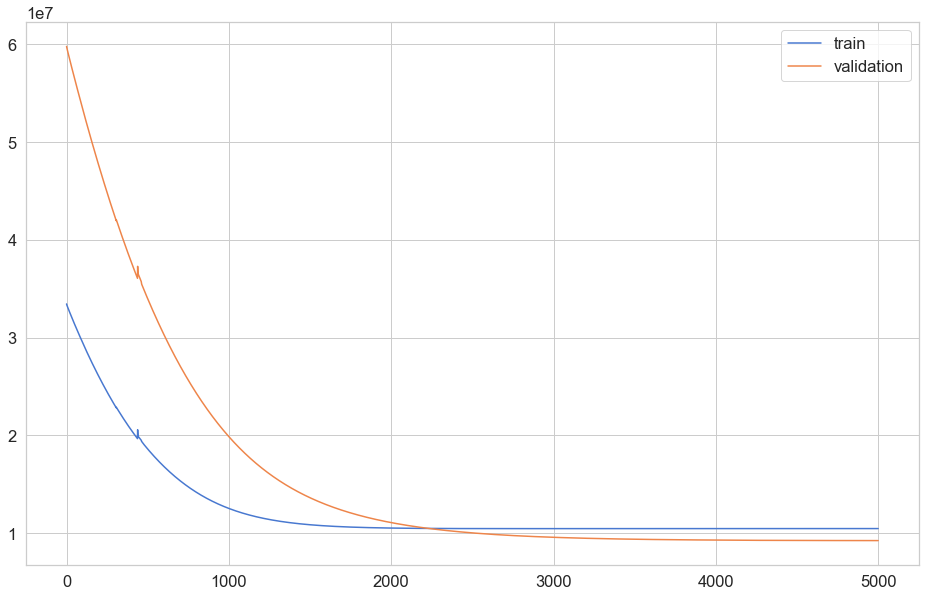

In [41]:
plot_history(history_1)

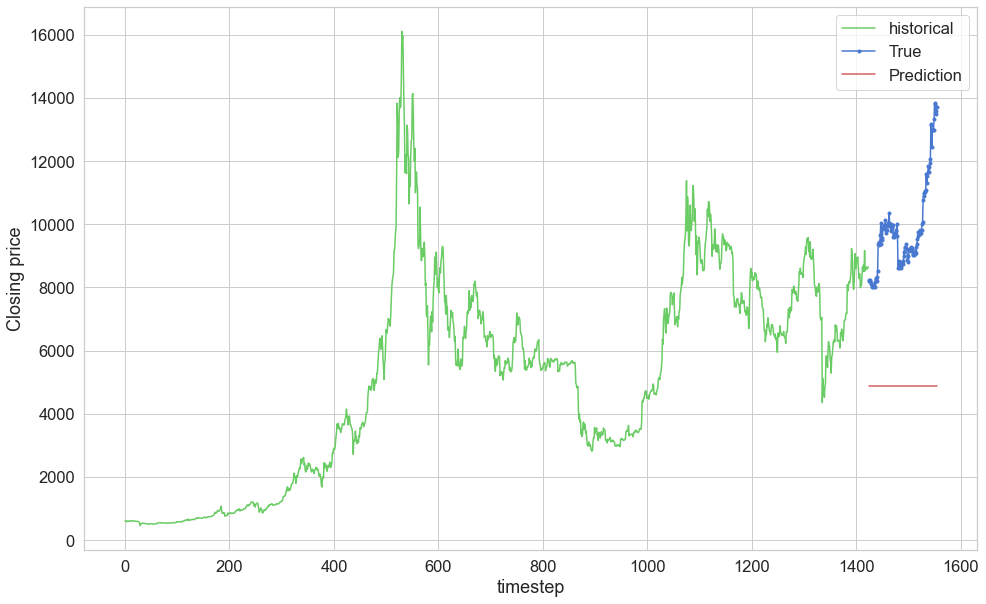

In [42]:
pred_1 = model_1.predict(X_test)

plot_all(y_train, y_test, pred_1)

In [43]:
print(pred_1[42], pred_1[84])

[4881.9023] [4881.9023]


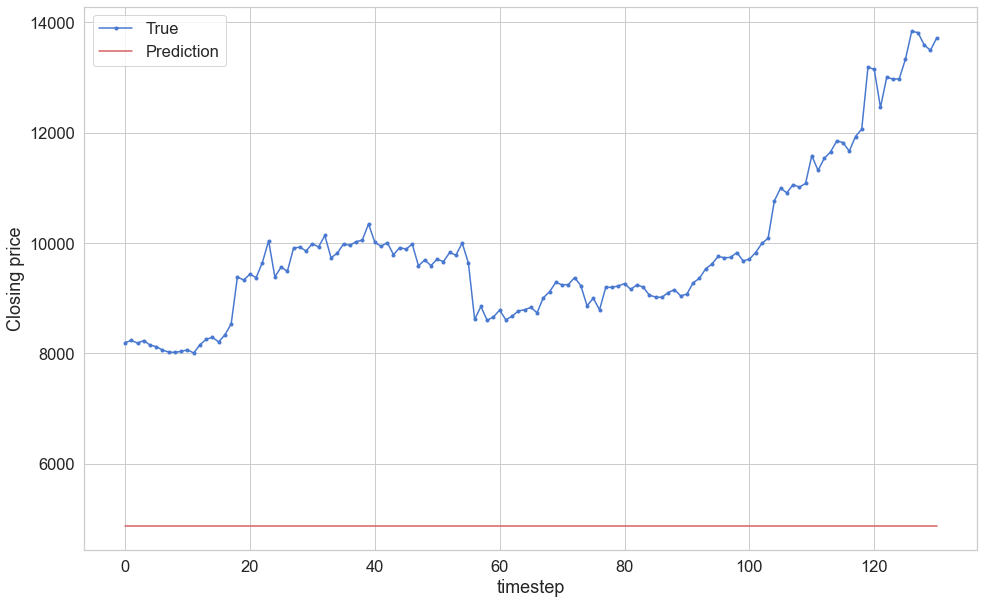

In [44]:
plot_detail(y_test, pred_1)

## Checkpoint and conclusion for now
As far as I understand LSTM, the periodicity of the data fed to the algorithm does not seem to be strong or obvious enough for the model to adapt within an above used number of epochs. Maybe the model would converge within 10 thousand epochs, who knows? According to the history above, the algorithm just learns to adjust and move up the final predicted line by a small amount.

For educational purposes, I am fine with the outcome of this notebook, even though the model does not work as intended. 

I have created the most inefficient, time-consuming constant regressor, e.g. mean calculator! yikes
